In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import random
from scipy.optimize import curve_fit

import ctypes
import numba as nb

# Problem 1

Fit parameter a: -0.00026 +\- 0.00576
Fit parameter b: 0.002 +\- 0.00573


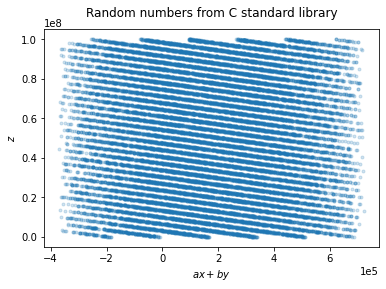

In [2]:
# ----------- First, retrieve the data --------------------------

rows = []
with open("rand_points.txt","r") as f:
    for i in f.readlines():
        cols = []
        for j in i.split():
            cols.append(int(j))
        rows.append(cols)
        
rows = np.asarray(rows)
x = rows[:,0]
y = rows[:,1]
z = rows[:,2]

# ------------------ Suitably choose a and b using scipy -----------------------------------

def fun(data,a,b,c):
    return a*data[:,0]+b*data[:,1]+c

popt, pcov = curve_fit(fun, np.stack([x,y]).T, z)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt[0],5),"+\-",round(np.sqrt(np.diag(pcov))[0],5))
print("Fit parameter b:",round(popt[1],5),"+\-",round(np.sqrt(np.diag(pcov))[1],5))

# Play around with it a little -- scipy isn't perfect!
a = popt[0] + 1.3*np.sqrt(np.diag(pcov))[0]
b = popt[1] - np.sqrt(np.diag(pcov))[1]

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a*x+b*y, z, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from C standard library",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#plt.savefig("problem1_broken.png",dpi=500,bbox_inches='tight')

plt.show()


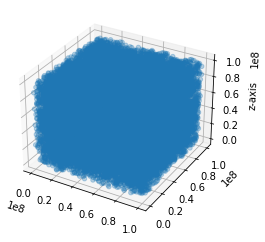

In [3]:
# ------------- Also show the corresponding 3d plot ---------------------------------

# %matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x,y,z,alpha=0.3)
ax.set_zlabel('z-axis')
plt.show()

In [4]:
# -------------------- Try again with Python's RNG -------------------------------

# Get a huge list of random numbers
n=300000000

# Initialize empty array
vec = np.empty(3*n, dtype='int32')

# Fill it with random numbers
for i in tqdm(range(vec.size)):
    vec[i] = random.randint(0,int(2**31))

# Split it into 3 columns
vv = np.reshape(vec, [n,3])

# Only keep values smaller than maxval
vmax = np.max(vv,axis=1)
maxval = 1e8
vv2 = vv[vmax<maxval,:]

# Save them because it takes a really long time to run this!
with open("rand_points_python.txt","w") as f:
    for i in range(vv2.shape[0]):
        myline = repr(vv2[i,0])+' '+repr(vv2[i,1])+' '+ repr(vv2[i,2])+'\n'
        f.write(myline)

100%|██████████| 900000000/900000000 [15:13<00:00, 985718.53it/s]


Fit parameter a: 0.00771 +\- 0.00576
Fit parameter b: -0.00292 +\- 0.00577


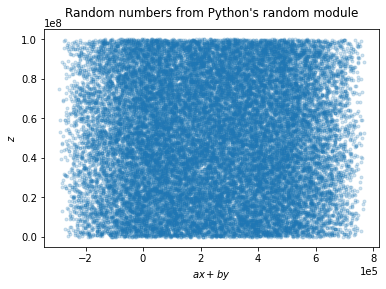

In [5]:
# -------------------- Check to see if Python random numbers are correlated ----------------------------

x_p = vv2[:,0]
y_p = vv2[:,1]
z_p = vv2[:,2]

popt_p, pcov_p = curve_fit(fun, np.stack([x_p,y_p]).T, z_p)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt_p[0],5),"+\-",round(np.sqrt(np.diag(pcov_p))[0],5))
print("Fit parameter b:",round(popt_p[1],5),"+\-",round(np.sqrt(np.diag(pcov_p))[1],5))

a_p = popt_p[0] 
b_p = popt_p[1] 

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a_p*x_p+b_p*y_p, z_p, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from Python's random module",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.savefig("problem1_unbroken.png",dpi=500,bbox_inches='tight')

plt.show()

In [6]:
# ----------------------- Finally, try the C standard library on my computer -----------------------

# Below: basically copy-pasted from test_broken_libc.py

####################################################################################################

mylib=ctypes.cdll.LoadLibrary("libc.so.6")
rand=mylib.rand
rand.argtypes=[]
rand.restype=ctypes.c_int


@nb.njit
def get_rands_nb(vals):
    n=len(vals)
    for i in range(n):
        vals[i]=rand()
    return vals

def get_rands(n):
    vec=np.empty(n,dtype='int32')
    get_rands_nb(vec)
    return vec


n=300000000
vec=get_rands(n*3)

vv=np.reshape(vec,[n,3])
vmax=np.max(vv,axis=1)

maxval=1e8
vv_me=vv[vmax<maxval,:]

f=open('rand_points_me.txt','w')
for i in range(vv_me.shape[0]):
    myline=repr(vv_me[i,0])+' '+repr(vv_me[i,1])+' '+ repr(vv_me[i,2])+'\n'
    f.write(myline)
f.close()

####################################################################################################

Fit parameter a: -0.00478 +\- 0.00573
Fit parameter b: -0.01389 +\- 0.00577


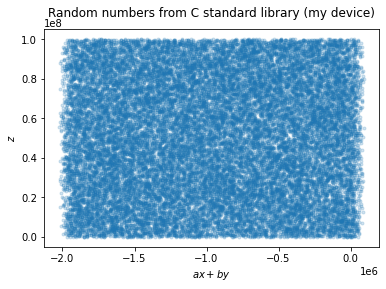

In [7]:
# -------------------- Find the correlation for my random numbers ----------------------------

x_me = vv_me[:,0]
y_me = vv_me[:,1]
z_me = vv_me[:,2]

popt_me, pcov_me = curve_fit(fun, np.stack([x_me,y_me]).T, z_me)

# Print the fit parameters and their uncertainties
print("Fit parameter a:",round(popt_me[0],5),"+\-",round(np.sqrt(np.diag(pcov_me))[0],5))
print("Fit parameter b:",round(popt_me[1],5),"+\-",round(np.sqrt(np.diag(pcov_me))[1],5))

# Play around with it a little -- scipy isn't perfect!
a_me = popt_me[0] + 1*np.sqrt(np.diag(pcov_me))[0]
b_me = popt_me[1] - 1.1*np.sqrt(np.diag(pcov_me))[1]

# ------------------------- Plot the result! -----------------------------------------------

plt.plot(a_me*x_me+b_me*y_me, z_me, '.', alpha=0.2)
plt.ylabel(r"$z$")
plt.xlabel(r"$ax+by$")
plt.title("Random numbers from C standard library (my device)",y=1.03)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.savefig("problem1_broken_me.png",dpi=500,bbox_inches='tight')

plt.show()

# Problem 2

## 1) Compare different bounding curves 

<ipython-input-8-c94b7206ce04>:12: RuntimeWarning: divide by zero encountered in power
  return (1-a)*x**(-a)


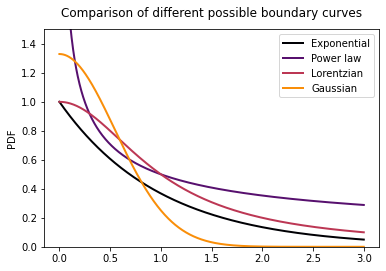

In [8]:
# -------------------- Color scheme for plots --------------------------------------------------

import matplotlib as m
colors = [1,2,3,4,5]
cmap = m.cm.get_cmap('inferno')
norm = m.colors.Normalize(vmin=np.min(colors), vmax=np.max(colors))

# --------------- Define boundary curve PDFs --------------------------------------------------

def power(x, a=0.5):
    ''' Power law PDF for with default a = 0.5'''
    return (1-a)*x**(-a)

def lorentz(x):
    ''' Lorentzian PDF '''
    return 1/(x**2 + 1)

def gaussian(x, mu=0, sigma=0.3):
    ''' Gaussian PDF with default mu = 0 and sigma = 0.3'''
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-1/(2*sigma) * (x-mu)**2)

# ---------------------------- Plot them -----------------------------------------------------

x = np.linspace(0,3,1000)

plt.plot(x, np.exp(-x), color=cmap(norm(colors[0])), linewidth=2, label="Exponential")
plt.plot(x, power(x), color=cmap(norm(colors[1])), linewidth=2, label="Power law")
plt.plot(x, lorentz(x), color=cmap(norm(colors[2])), linewidth=2, label="Lorentzian")
plt.plot(x, gaussian(x), color=cmap(norm(colors[3])), linewidth=2, label="Gaussian")

plt.ylabel("PDF")
plt.title("Comparison of different possible boundary curves",y=1.03)
plt.legend()
plt.ylim(0,1.5)

plt.savefig("boundary_curves.png",dpi=500,bbox_inches='tight')

plt.show()

## 2) First Idea: Lorentzian

Choose a Lorentzian of the form

\begin{equation}
f(x) = \frac{1}{x^2 + 1}
\end{equation}

which is greater than the exponential on $[0, \infty)$.

100%|██████████| 1000000/1000000 [00:03<00:00, 314468.63it/s]


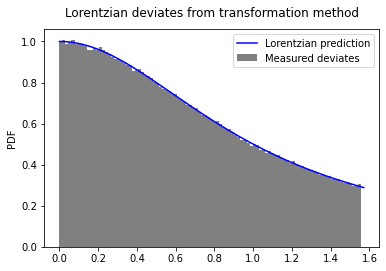

In [9]:
# ------------ Set up Lorentzian PRNG ----------------------

def get_lorentz(x):
    ''' Get power law from uniform PDF '''
    return np.tan(x)  # Inverted CDF

# ------------------ Make sure it works ------------------------------------

num = 1000000

x = np.zeros(num)

for i in tqdm(range(num)):
    
    rv = np.random.uniform()
    
    x[i] = get_lorentz(rv)
    
plt.hist(x, bins=100, density=True, color='grey', label="Measured deviates")

t = np.linspace(0,np.pi/2,1000)
plt.plot(t, lorentz(t), color='blue', label="Lorentzian prediction")
plt.legend()
plt.ylabel("PDF")
plt.title("Lorentzian deviates from transformation method", y=1.03)

plt.savefig("lorentz.png",dpi=500,bbox_inches='tight')

plt.show()

100%|██████████| 1000000/1000000 [00:07<00:00, 135631.79it/s]


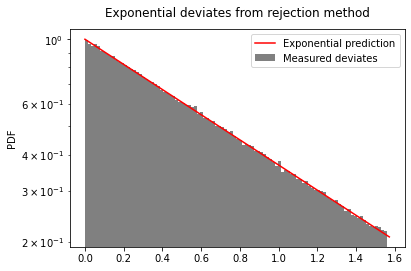

78.93% of Lorentzian deviates give rise to an exponential deviate


In [10]:
# ------------------------- Use rejection method --------------------------------

accepted = []  # List of accepted x-values

for i in tqdm(range(num)):
    
    # Pick a uniform deviate between 0 and 1

    rv1 = np.random.uniform()

    # Use it to get a corresponding x distributed according to bounding curve

    corresponding_x = get_lorentz(rv1)

    # Get corresponding y-value (f(x))

    fx = lorentz(corresponding_x)
    
    rv2 = np.random.uniform(0, fx)

    # Accept or reject according to whether it it respectively less than or greater than P(x)

    if rv2 < np.exp(-corresponding_x):
        accepted.append(corresponding_x)
        
accepted = np.asarray(accepted)

# ----------------------- Plot it! -------------------------------------------------

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

# First, grab histogram counts and bins
n, bins = np.histogram(accepted, bins=100)

# Now, normalize it --> IMPORTANT: do NOT normalize to 1!!!! np.exp(-x) on [0,pi/2] normalizes to 1-e^(-pi/2), not 1!!!!
density = n/(sum(n)*np.diff(bins))
density = density * (1 - np.exp(-np.pi/2)) # Normalization factor

plt.hist(bins[:-1], bins, weights=density, color='grey', label="Measured deviates")

plt.plot(t, np.exp(-t), color='red', label=r"Exponential prediction")
plt.title("Exponential deviates from rejection method",y=1.03)
plt.ylabel("PDF")
plt.yscale("log")

plt.legend()

# plt.savefig("rejection_lorentz_log.png",dpi=500,bbox_inches='tight')

plt.show()

# -------------------- Finally, find the efficiency ---------------------------------

frac = accepted.size/num

print(f"{round(frac*100,2)}% of Lorentzian deviates give rise to an exponential deviate")

## 3) Second Idea: Power Law

Choose a power law of the form:

\begin{equation}
P(x) = 0.5x^{-0.5}
\end{equation}

which is always greater than the exponential on $[0,1]$.

<ipython-input-8-c94b7206ce04>:12: RuntimeWarning: divide by zero encountered in power
  return (1-a)*x**(-a)


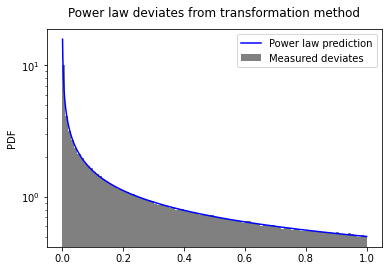

In [11]:
# -------------- Set up a power-law PRNG ----------------------------------

def get_power(x):
    ''' Get power law from uniform PDF '''
    return x**2  # Inverted CDF

# ------------ Test to make sure it works ---------------------------------

num = 1000000

x = np.random.uniform(size=num)
p = get_power(x)
plt.hist(p, density=True, bins=100, color='grey', label="Measured deviates")

t = np.linspace(0,1,1000)
plt.plot(t, power(t), color='blue',label=r"Power law prediction")
plt.yscale("log")
plt.ylabel("PDF")
plt.title("Power law deviates from transformation method",y=1.03)
plt.legend()

#plt.savefig("pwrlw.png",dpi=500,bbox_inches='tight')

plt.show()
    

100%|██████████| 1000000/1000000 [00:05<00:00, 180342.24it/s]


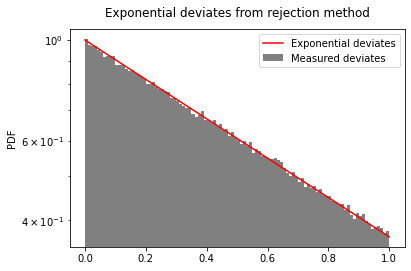

63.2% of uniform deviates give rise to an exponential deviate


In [12]:
# ------------------------- Use rejection method --------------------------------

accepted = []  # List of accepted x-values

for i in tqdm(range(num)):
    
    # Pick a uniform deviate between 0 and 1

    rv1 = np.random.uniform()

    # Use it to get a corresponding x distributed according to bounding curve

    corresponding_x = get_power(rv1)

    # Get corresponding y-value (f(x))

    fx = power(corresponding_x)
    
    rv2 = np.random.uniform(0, fx)

    # Accept or reject according to whether it it respectively less than or greater than P(x)

    if rv2 < np.exp(-corresponding_x):
        accepted.append(corresponding_x)
        
accepted = np.asarray(accepted)

# ----------------------- Plot it! -------------------------------------------------

# First, grab histogram counts and bins
n, bins = np.histogram(accepted, bins=100)

# Now, normalize it --> IMPORTANT: do NOT normalize to 1!!!! np.exp(-x) on [0,1] normalizes to 1-e^(-1), not 1!!!!
density = n/(sum(n)*np.diff(bins))
density = density * (1 - np.exp(-1)) # Normalization factor

plt.hist(bins[:-1], bins, weights=density, color='grey', label="Measured deviates")

plt.plot(t, np.exp(-t), color='red', label=r"Exponential deviates")
plt.title("Exponential deviates from rejection method",y=1.03)
plt.ylabel("PDF")
plt.yscale("log")

plt.legend()

#plt.savefig("rejection_pwrlw_log.png",dpi=500,bbox_inches='tight')

plt.show()

# -------------------- Finally, find the efficiency ---------------------------------

frac = accepted.size/num

print(f"{round(frac*100,2)}% of uniform deviates give rise to an exponential deviate")


# Problem 3

1) Construct the region in the (u,v) plane bounded by $0 \leq u \leq [p(v/u)]^{\frac{1}{2}}$, where $p(x) = e^{-x}$ and $x = \frac{v}{u}$.\
2) Sample uniformly in the teardrop region\
3) Return v/u if (u,v) pair in the teardrop

<ipython-input-13-5929e89569a4>:5: RuntimeWarning: divide by zero encountered in log
  v = u*np.log(u**2)
<ipython-input-13-5929e89569a4>:5: RuntimeWarning: invalid value encountered in multiply
  v = u*np.log(u**2)


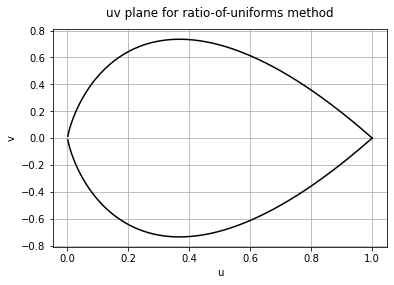

If u goes from 0 to 1, v goes from -0.7358 to 0.7358


In [13]:
# Set up the uv plane

u = np.linspace(0,1,1000)

v = u*np.log(u**2)

plt.plot(u, v, color='k')
plt.plot(u,-v, color='k')

plt.xlabel("u")
plt.ylabel("v")
plt.title("uv plane for ratio-of-uniforms method",y=1.03)
plt.grid()

plt.savefig("uv_plane.png",dpi=500,bbox_inches='tight')

plt.show()

# Get lower and upper limits on v

v_lower = min(v[1:])
v_upper = - min(v[1:])

print("If u goes from 0 to 1, v goes from",round(v_lower,4),"to",round(v_upper,4))


In [14]:
# Start sampling!

ratio = np.zeros(num)

for i in tqdm(range(num)):

    # Sample two random uniform positions u and v
    rv_u = np.random.uniform(0,1)
    rv_v = np.random.uniform(v_lower, v_upper)
    
    # Make sure the pair is in the teardrop
    if (rv_v >= rv_u*np.log(rv_u**2)) and (rv_v <= -rv_u*np.log(rv_u**2)):
        
        ratio[i] = rv_v/rv_u
        

100%|██████████| 1000000/1000000 [00:06<00:00, 162091.54it/s]


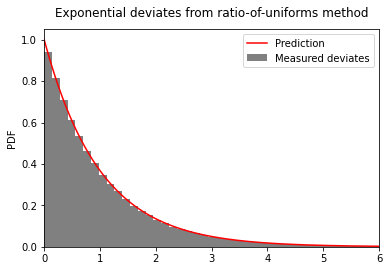

33.96% of uniform deviates give rise to an exponential deviate


In [15]:
# ------------------------ Plot deviates! -------------------------------------------------------------

ratio = ratio[(ratio > 0)]  # We only care about the positive part

plt.hist(ratio, bins=100, density=True, color='grey', label="Measured deviates")

t = np.linspace(0,6,10000)
plt.plot(t, np.exp(-t), color='red', label="Prediction")
plt.xlim(0,6)
plt.title("Exponential deviates from ratio-of-uniforms method",y=1.03)
plt.ylabel("PDF")
plt.legend()

#plt.yscale("log")

#plt.savefig("Problem3.png",dpi=500,bbox_inches='tight')

plt.show()

# --------------------- Finally, give the efficiency -------------------------------------------------

frac = ratio.size/num

print(f"{round(frac*100,2)}% of uniform deviates give rise to an exponential deviate")